# ------------------- EDA2 ------------------------

In [19]:
# ==============================================================================
# 0. SETUP: Import Libraries
# ==============================================================================
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble import IsolationForest
# For PPS Score calculation, 'ppscore' is required. If not installed, this part will be skipped.
try:
    import ppscore as pps
    PPS_AVAILABLE = True
except ImportError:
    print("Warning: ppscore library not found. Skipping PPS calculation.")
    PPS_AVAILABLE = False

# Set options for better output display
pd.set_option('display.max_columns', None)
np.random.seed(42)

In [20]:
# ==============================================================================
# 1. DATA EXPLORATION AND PREPROCESSING
# ==============================================================================

print("--- 1. Data Exploration and Preprocessing ---")

# Load the dataset
df = pd.read_csv('adult_with_headers.csv')

# Clean column names and object data (remove leading/trailing spaces)
df.columns = df.columns.str.strip()
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].str.strip()

print("Initial Data Shape:", df.shape)
print("\nInitial Data Types:\n", df.dtypes)
print("\nInitial Missing Values (marked by '?'):")

# Identify '?' as missing values
df = df.replace('?', np.nan)
print(df.isnull().sum())

# Handle Missing Values: Impute categorical features with the Mode
categorical_cols = df.select_dtypes(include='object').columns.tolist()
for col in ['workclass', 'occupation', 'native_country']: # These are the columns with missing '?' values
    df[col] = df[col].fillna(df[col].mode()[0])

print("\nMissing values after mode imputation:\n", df.isnull().sum().sum())

# Separate feature types for later use
numerical_cols = ['age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']
categorical_cols = df.select_dtypes(include='object').columns.tolist()



--- 1. Data Exploration and Preprocessing ---
Initial Data Shape: (32561, 15)

Initial Data Types:
 age                int64
workclass         object
fnlwgt             int64
education         object
education_num      int64
marital_status    object
occupation        object
relationship      object
race              object
sex               object
capital_gain       int64
capital_loss       int64
hours_per_week     int64
native_country    object
income            object
dtype: object

Initial Missing Values (marked by '?'):
age                  0
workclass         1836
fnlwgt               0
education            0
education_num        0
marital_status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital_gain         0
capital_loss         0
hours_per_week       0
native_country     583
income               0
dtype: int64

Missing values after mode imputation:
 0


In [21]:
# ==============================================================================
# 3. FEATURE ENGINEERING
# (Executed before scaling and final encoding/selection)
# ==============================================================================

print("\n--- 3. Feature Engineering ---")

# --- 3a. Transformation on Skewed Numerical Features ---
# Features 'capital_gain' and 'capital_loss' are highly skewed and contain many zeros.
# A log transformation (np.log1p) is applied to reduce skewness and compress the large range of values.
# Rationale: This transformation makes the distribution closer to normal, which is beneficial for linear models.
df['capital_gain_log'] = np.log1p(df['capital_gain'])
df['capital_loss_log'] = np.log1p(df['capital_loss'])
df = df.drop(columns=['capital_gain', 'capital_loss'])
print("Applied log transformation to capital_gain and capital_loss.")

# Update numerical features list
numerical_cols_final = ['age', 'fnlwgt', 'education_num', 'hours_per_week',
                        'capital_gain_log', 'capital_loss_log']

# --- 3b. Create at least 2 new features ---

# New Feature 1: Capital Indicator
# Rationale: The sheer presence of a capital gain or loss is often more informative than the magnitude itself, given the sparsity.
df['Capital_Indicator'] = ((df['capital_gain_log'] > 0) | (df['capital_loss_log'] > 0)).astype(int)
numerical_cols_final.append('Capital_Indicator')
print("Created 'Capital_Indicator' feature.")

# New Feature 2: Combined Work Load (age * hours_per_week)
# Rationale: A measure of a person's total work contribution across their life up to this point.
df['Lifetime_Work_Proxy'] = df['age'] * df['hours_per_week']
numerical_cols_final.append('Lifetime_Work_Proxy')
print("Created 'Lifetime_Work_Proxy' feature.")




--- 3. Feature Engineering ---
Applied log transformation to capital_gain and capital_loss.
Created 'Capital_Indicator' feature.
Created 'Lifetime_Work_Proxy' feature.


In [22]:
# ==============================================================================
# 4. FEATURE SELECTION: Outlier Removal (Isolation Forest)
# ==============================================================================

print("\n--- 4. Outlier Detection and Removal (Isolation Forest) ---")

# Use Isolation Forest on the numerical features to detect multivariate outliers
iso_forest = IsolationForest(random_state=42, contamination=0.01) # Assume 1% outliers for robust estimation
outlier_preds = iso_forest.fit_predict(df[numerical_cols_final])

# Filter out outliers (where prediction is -1)
df_clean = df[outlier_preds == 1].copy()

outliers_removed = df.shape[0] - df_clean.shape[0]
print(f"Original samples: {df.shape[0]}, Outliers removed: {outliers_removed}, Clean samples: {df_clean.shape[0]}")




--- 4. Outlier Detection and Removal (Isolation Forest) ---
Original samples: 32561, Outliers removed: 326, Clean samples: 32235


In [23]:
# ==============================================================================
# 1. DATA EXPLORATION AND PREPROCESSING (CONTINUED: SCALING)
# ==============================================================================

print("\n--- 1. Data Scaling (Standard & Min-Max) ---")

scaler_data = df_clean[numerical_cols_final]

# Apply Standard Scaling
scaler_standard = StandardScaler()
df_standard_scaled = scaler_standard.fit_transform(scaler_data)
df_standard_scaled = pd.DataFrame(df_standard_scaled, columns=[f'{col}_std' for col in numerical_cols_final], index=df_clean.index)

# Apply Min-Max Scaling
scaler_minmax = MinMaxScaler()
df_minmax_scaled = scaler_minmax.fit_transform(scaler_data)
df_minmax_scaled = pd.DataFrame(df_minmax_scaled, columns=[f'{col}_minmax' for col in numerical_cols_final], index=df_clean.index)

print("Standard Scaled Data Head:")
print(df_standard_scaled.head())
print("\nMin-Max Scaled Data Head:")
print(df_minmax_scaled.head())


--- 1. Data Scaling (Standard & Min-Max) ---
Standard Scaled Data Head:
    age_std  fnlwgt_std  education_num_std  hours_per_week_std  \
0  0.043889   -1.065819           1.150146           -0.028695   
1  0.859869   -1.010619           1.150146           -2.266961   
2 -0.030291    0.249931          -0.420860           -0.028695   
3  1.082409    0.431629          -1.206363           -0.028695   
4 -0.772091    1.419303           1.150146           -0.028695   

   capital_gain_log_std  capital_loss_log_std  Capital_Indicator_std  \
0              2.897512             -0.207571               2.686824   
1             -0.293544             -0.207571              -0.372187   
2             -0.293544             -0.207571              -0.372187   
3             -0.293544             -0.207571              -0.372187   
4             -0.293544             -0.207571              -0.372187   

   Lifetime_Work_Proxy_std  
0                -0.000499  
1                -1.268344  
2         

In [24]:
# ==============================================================================
# 2. ENCODING TECHNIQUES
# ==============================================================================

print("\n--- 2. Encoding Techniques (One-Hot & Label) ---")

categorical_features = [col for col in df_clean.select_dtypes(include='object').columns if col != 'income']

# Find categories based on unique value count as per assignment instructions
small_categories = [col for col in categorical_features if df_clean[col].nunique() < 5] # e.g., 'sex', 'race'
large_categories = [col for col in categorical_features if df_clean[col].nunique() >= 5] # e.g., 'workclass', 'occupation', 'native_country'

print(f"Small Categories (< 5 unique values): {small_categories}")
print(f"Large Categories (>= 5 unique values): {large_categories}")

# One-Hot Encoding for small categories
df_encoded_ohe = pd.get_dummies(df_clean[small_categories], prefix=small_categories, drop_first=True)

# Label Encoding for large categories (as per prompt)
# Note: LabelEncoder is typically for ordinal data, or the target. Using it on nominal data (like occupation) imposes an arbitrary order.
df_encoded_le = pd.DataFrame(index=df_clean.index)
for col in large_categories:
    le = LabelEncoder()
    df_encoded_le[col] = le.fit_transform(df_clean[col])

print("\nOne-Hot Encoded Features Shape:", df_encoded_ohe.shape)
print("Label Encoded Features Shape:", df_encoded_le.shape)

# Encode the target variable 'income'
le_income = LabelEncoder()
df_clean['income_encoded'] = le_income.fit_transform(df_clean['income'])

# Final Combined DataFrame (using Standard Scaled numerical features)
df_final = pd.concat([
    df_standard_scaled,
    df_encoded_ohe,
    df_encoded_le,
    df_clean[['income_encoded']] # Target variable
], axis=1)

print("\nFinal Preprocessed Data Shape:", df_final.shape)




--- 2. Encoding Techniques (One-Hot & Label) ---
Small Categories (< 5 unique values): ['sex']
Large Categories (>= 5 unique values): ['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'native_country']

One-Hot Encoded Features Shape: (32235, 1)
Label Encoded Features Shape: (32235, 7)

Final Preprocessed Data Shape: (32235, 17)


In [25]:
# ==============================================================================
# 4. FEATURE SELECTION (CONTINUED: PPS & CORRELATION)
# ==============================================================================

print("\n--- 4. Feature Selection: PPS and Correlation Analysis ---")

# Calculate Correlation Matrix (Pearson)
print("\nCorrelation with Target (income_encoded):")
corr_to_target = df_final.corr()['income_encoded'].sort_values(ascending=False).drop('income_encoded')
print(corr_to_target)

if PPS_AVAILABLE:
    # Calculate PPS matrix
    print("\nPredictive Power Score (PPS) Matrix:")
    pps_matrix = pps.matrix(df_final.drop(columns=['income_encoded']))
    pps_to_target = pps_matrix.query("y == 'income_encoded'").sort_values(by='ppscore', ascending=False)[['x', 'ppscore']]
    print(pps_to_target)



--- 4. Feature Selection: PPS and Correlation Analysis ---

Correlation with Target (income_encoded):
education_num_std          0.329528
Lifetime_Work_Proxy_std    0.321161
Capital_Indicator_std      0.299130
capital_gain_log_std       0.288290
age_std                    0.230503
hours_per_week_std         0.225403
sex_Male                   0.214769
capital_loss_log_std       0.130008
education                  0.077927
race                       0.070106
occupation                 0.033161
native_country             0.023133
workclass                 -0.002280
fnlwgt_std                -0.012056
marital_status            -0.198712
relationship              -0.249939
Name: income_encoded, dtype: float64



--- Visualization of Preprocessing and Relationships ---


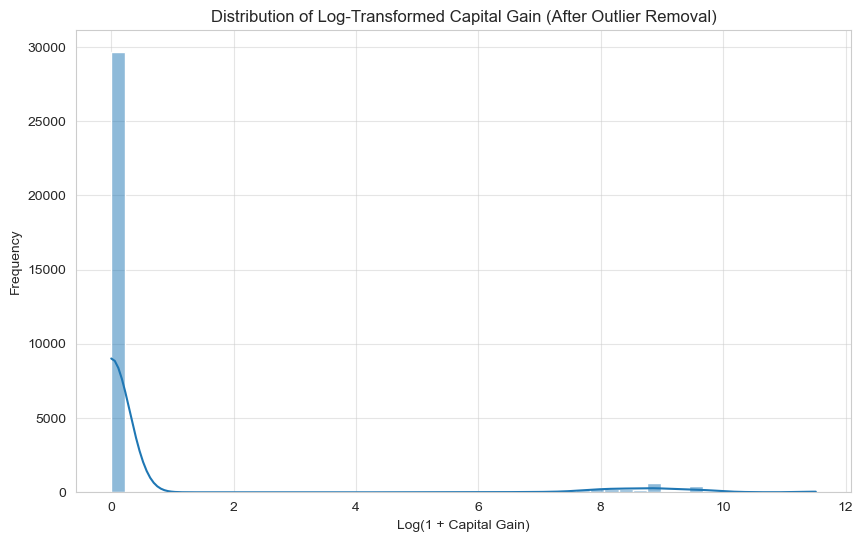

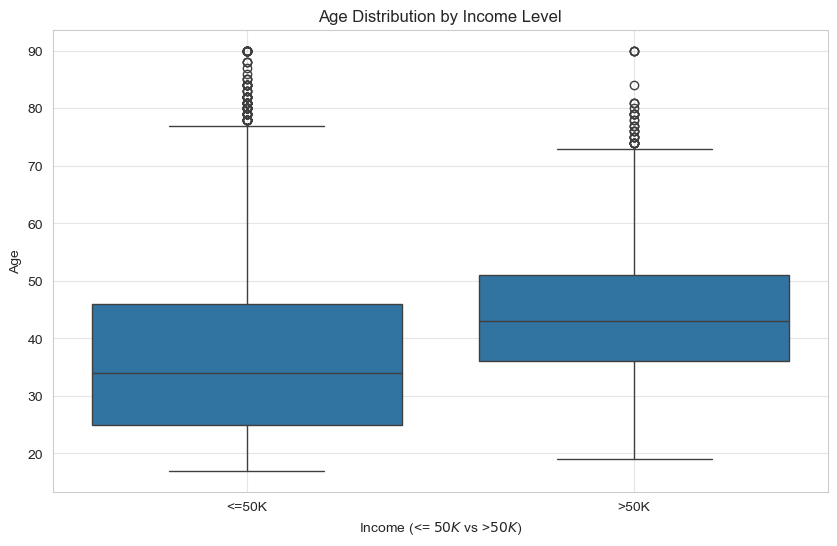

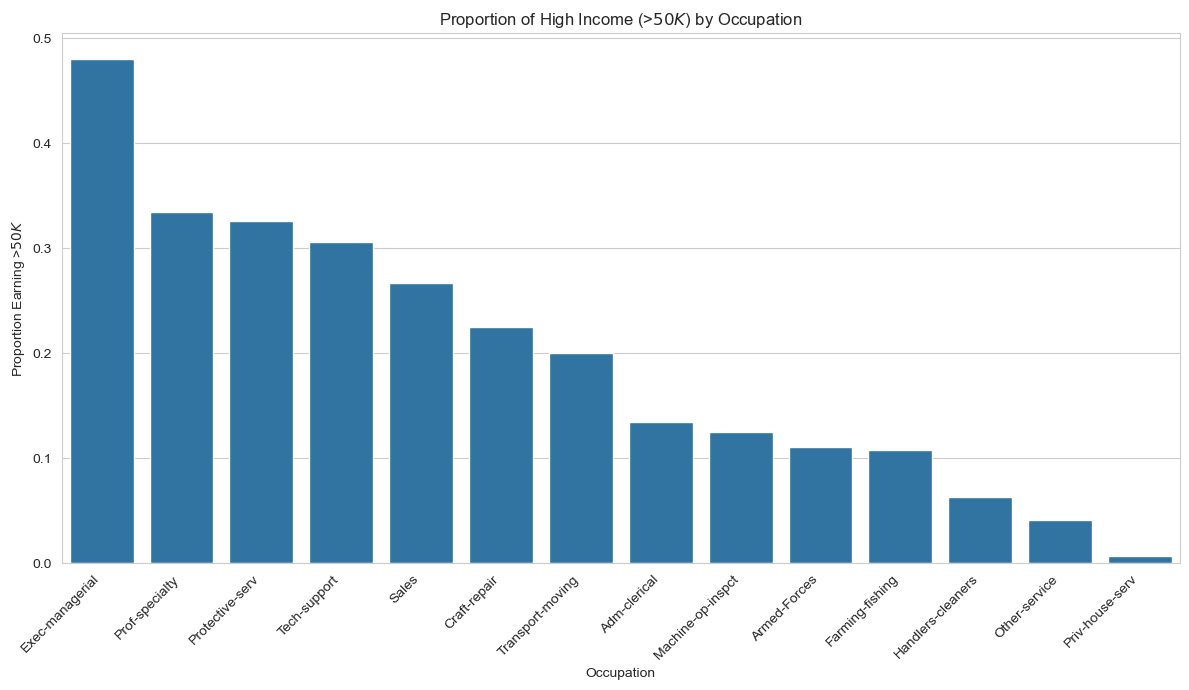

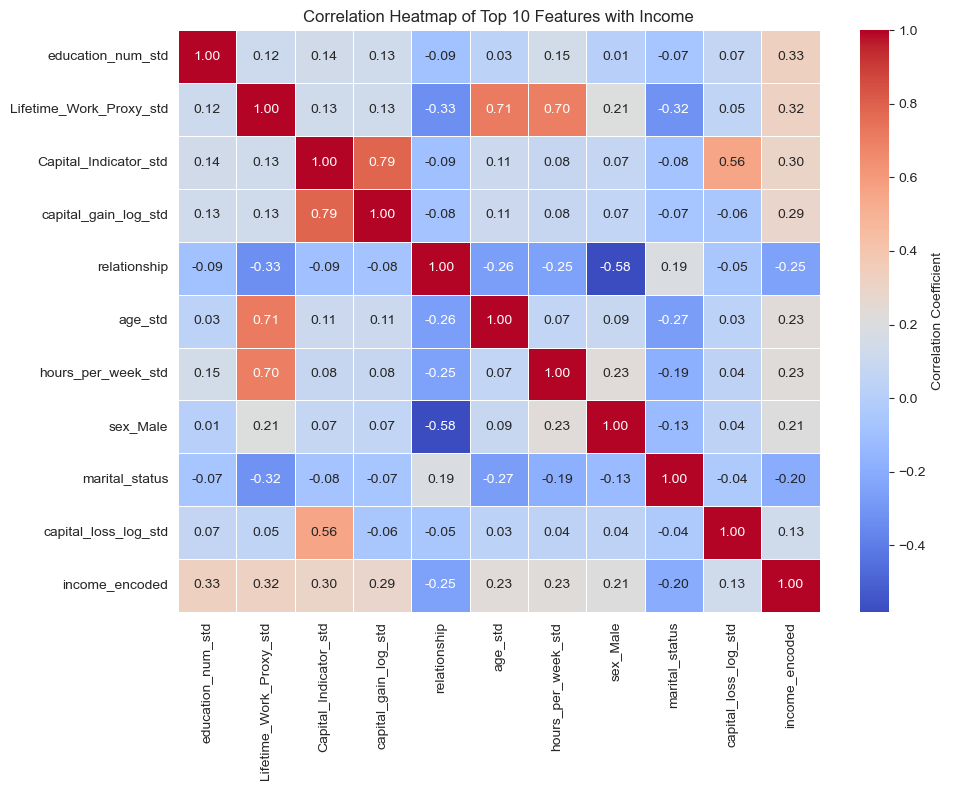

In [29]:
# ==============================================================================
# VISUALIZATION 
# ==============================================================================

print("\n--- Visualization of Preprocessing and Relationships ---")

# 1. Distribution of a Transformed Feature (capital_gain_log)
plt.figure(figsize=(10, 6))
sns.histplot(df_clean['capital_gain_log'], bins=50, kde=True)
plt.title('Distribution of Log-Transformed Capital Gain (After Outlier Removal)')
plt.xlabel('Log(1 + Capital Gain)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.5)
plt.savefig('capital_gain_log_distribution.png')
plt.show()

# 2. Relationship between a Numerical Feature and Target (Age vs Income)
plt.figure(figsize=(10, 6))
sns.boxplot(x='income', y='age', data=df_clean)
plt.title('Age Distribution by Income Level')
plt.xlabel('Income (<= $50K$ vs >$50K$)')
plt.ylabel('Age')
plt.grid(True, alpha=0.5)
plt.savefig('age_vs_income_boxplot.png')
plt.show()

# 3. Relationship between a High-Cardinality Encoded Feature and Target (Occupation)
occupation_income = df_clean.groupby('occupation')['income_encoded'].mean().sort_values(ascending=False)
plt.figure(figsize=(12, 7))
sns.barplot(x=occupation_income.index, y=occupation_income.values)
plt.title('Proportion of High Income (>$50K$) by Occupation')
plt.xlabel('Occupation')
plt.ylabel('Proportion Earning >$50K$')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('occupation_vs_income_proportion.png')
plt.show()

# 4. Correlation Heatmap (Top 10 features correlating with income)
corr_matrix = df_final.corr()
target_corr = corr_matrix['income_encoded'].abs().sort_values(ascending=False)
top_10_features = target_corr.index[1:11] # Exclude income_encoded itself
features_for_heatmap = top_10_features.tolist() + ['income_encoded']
corr_subset = df_final[features_for_heatmap].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_subset, annot=True, fmt=".2f", cmap='coolwarm', linewidths=.5, cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Correlation Heatmap of Top 10 Features with Income')
plt.tight_layout()
plt.savefig('top_10_features_correlation_heatmap.png')
plt.show()

# THEORETICAL DISCUSSIONS
## Discussion: How Outliers Affect Model Performance
Outliers can severely impact machine learning models, particularly those based on distance metrics (like K-Nearest Neighbors, K-Means) or linear assumptions (like Linear Regression, Logistic Regression).

- Bias: Outliers can disproportionately shift the model's parameters, leading to a biased fit. For example, in linear regression, a single extreme point can tilt the entire regression line.

- Distorted Scaling: They heavily influence the mean and standard deviation, which are the basis for Standard Scaling, potentially compressing the range of normal data points after scaling.

The Isolation Forest was used to identify and remove samples that were isolated in the feature space, leading to a cleaner and more robust training set.

## Discussion: Standard Scaling vs. Min-Max Scaling
**Standard Scaling (Z-score normalization)**
Transforms data to have a mean (μ) of 0 and a standard deviation (σ) of 1. Formula: X 
scaled
​
 =(X−μ)/σ.

- When preferred: Used when the data follows a normal distribution or when the algorithm assumes a standard normal distribution (e.g., Linear Regression, K-Means Clustering). It does not bound the data to a specific range.

**Min-Max Scaling (Normalization)**
Transforms data to a fixed range, typically between 0 and 1. Formula: X 
scaled
​
 =(X−X 
min
​
 )/(X 
max
​
 −X 
min
​
 ).

- When preferred: Used when the distribution of data is not Gaussian or when the model requires a fixed, small range of input values (e.g., Neural Networks). It is sensitive to extreme outliers.

## Discussion: One-Hot Encoding vs. Label Encoding
**One-Hot Encoding (OHE)**
Creates a new binary (0 or 1) column for each unique category. Used for nominal variables with low cardinality (<5 categories).

- Pros: Eliminates the false sense of order or magnitude between categories. Required for nominal data.

- Cons: Leads to the 'curse of dimensionality' if the feature has many unique categories.

**Label Encoding (LE)**
Converts each category into a unique integer label. Used for variables with high cardinality (≥5 categories).

- Pros: Simple and computationally cheap. Does not increase the number of features.

- Cons: Introduces an arbitrary ordinal relationship which is misleading for nominal data and can confuse many models (e.g., linear models, distance-based algorithms).

## Discussion: Feature Engineering Rationale
- Log Transformation of Capital Features: The capital_gain and capital_loss features were extremely sparse and skewed. The log(1+x) transformation reduced the skewness, making the features more suitable for linear models by reducing the influence of extreme values and making the distribution closer to normal.

- Capital Indicator: Creating a binary feature indicating the presence of any capital movement (Capital_Indicator) helps capture the non-linear importance of whether a person has an active investment portfolio, separate from the specific dollar amount.

- Lifetime Work Proxy: The feature Age×HoursPerWeek (Lifetime_Work_Proxy) serves as a composite measure of accumulated experience or career tenure, often highly correlated with income.